In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# Constants
ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'
ADDITIONAL_TOKENS = ['<OTHER>', '<START>', '<END>', '<PAD>']
ADDED_TOKENS_PER_SEQ = 2

# Preprocessing 
n_aas = len(ALL_AAS)
aa_to_token_index = {aa: i for i, aa in enumerate(ALL_AAS)}
additional_token_to_index = {token: i + n_aas for i, token in enumerate(ADDITIONAL_TOKENS)}
token_to_index = {**aa_to_token_index, **additional_token_to_index}
index_to_token = {index: token for token, index in token_to_index.items()}
n_tokens = len(token_to_index)


def parse_seq(seq):
    """Decodes sequence if it is in bytes"""
    if isinstance(seq, str):
        return seq
    elif isinstance(seq, bytes):
        return seq.decode('utf8')
    else:
        raise TypeError('Unexpected sequence type: %s' % type(seq))

def tokenize_seq(seq):
    """Converts sequence of amino acids into a list of token indices."""
    other_token_index = additional_token_to_index['<OTHER>']
    return [additional_token_to_index['<START>']] + [aa_to_token_index.get(aa, other_token_index) for aa in parse_seq(seq)] + [additional_token_to_index['<END>']]

def tokenize_seqs(seqs, seq_len):
    """Converts list of sequences into array of token indices."""
    return np.array([seq_tokens + (seq_len - len(seq_tokens)) * [additional_token_to_index['<PAD>']] for seq_tokens in map(tokenize_seq, seqs)], dtype = np.int32)

model = tf.keras.models.load_model("./proteinbert_models/proteinBERT_full/5")


datasets = []
models = []

file = 0



Processing dataset 1/15
Processing dataset 2/15
Processing dataset 3/15
Processing dataset 4/15
Processing dataset 5/15
Processing dataset 6/15
Processing dataset 7/15
Processing dataset 8/15
Processing dataset 9/15
Processing dataset 10/15
Processing dataset 11/15
Processing dataset 12/15
Processing dataset 13/15
Processing dataset 14/15
Processing dataset 15/15
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3837 samples in 0.036s...
[t-SNE] Computed neighbors for 3837 samples in 6.460s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3837
[t-SNE] Computed conditional probabilities for sample 2000 / 3837
[t-SNE] Computed conditional probabilities for sample 3000 / 3837
[t-SNE] Computed conditional probabilities for sample 3837 / 3837
[t-SNE] Mean sigma: 3.399808
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.271553
[t-SNE] KL divergence after 1000 iterations: 1.836707
Processing dataset 1/15
Processing dataset 2/15
Processing dataset 3

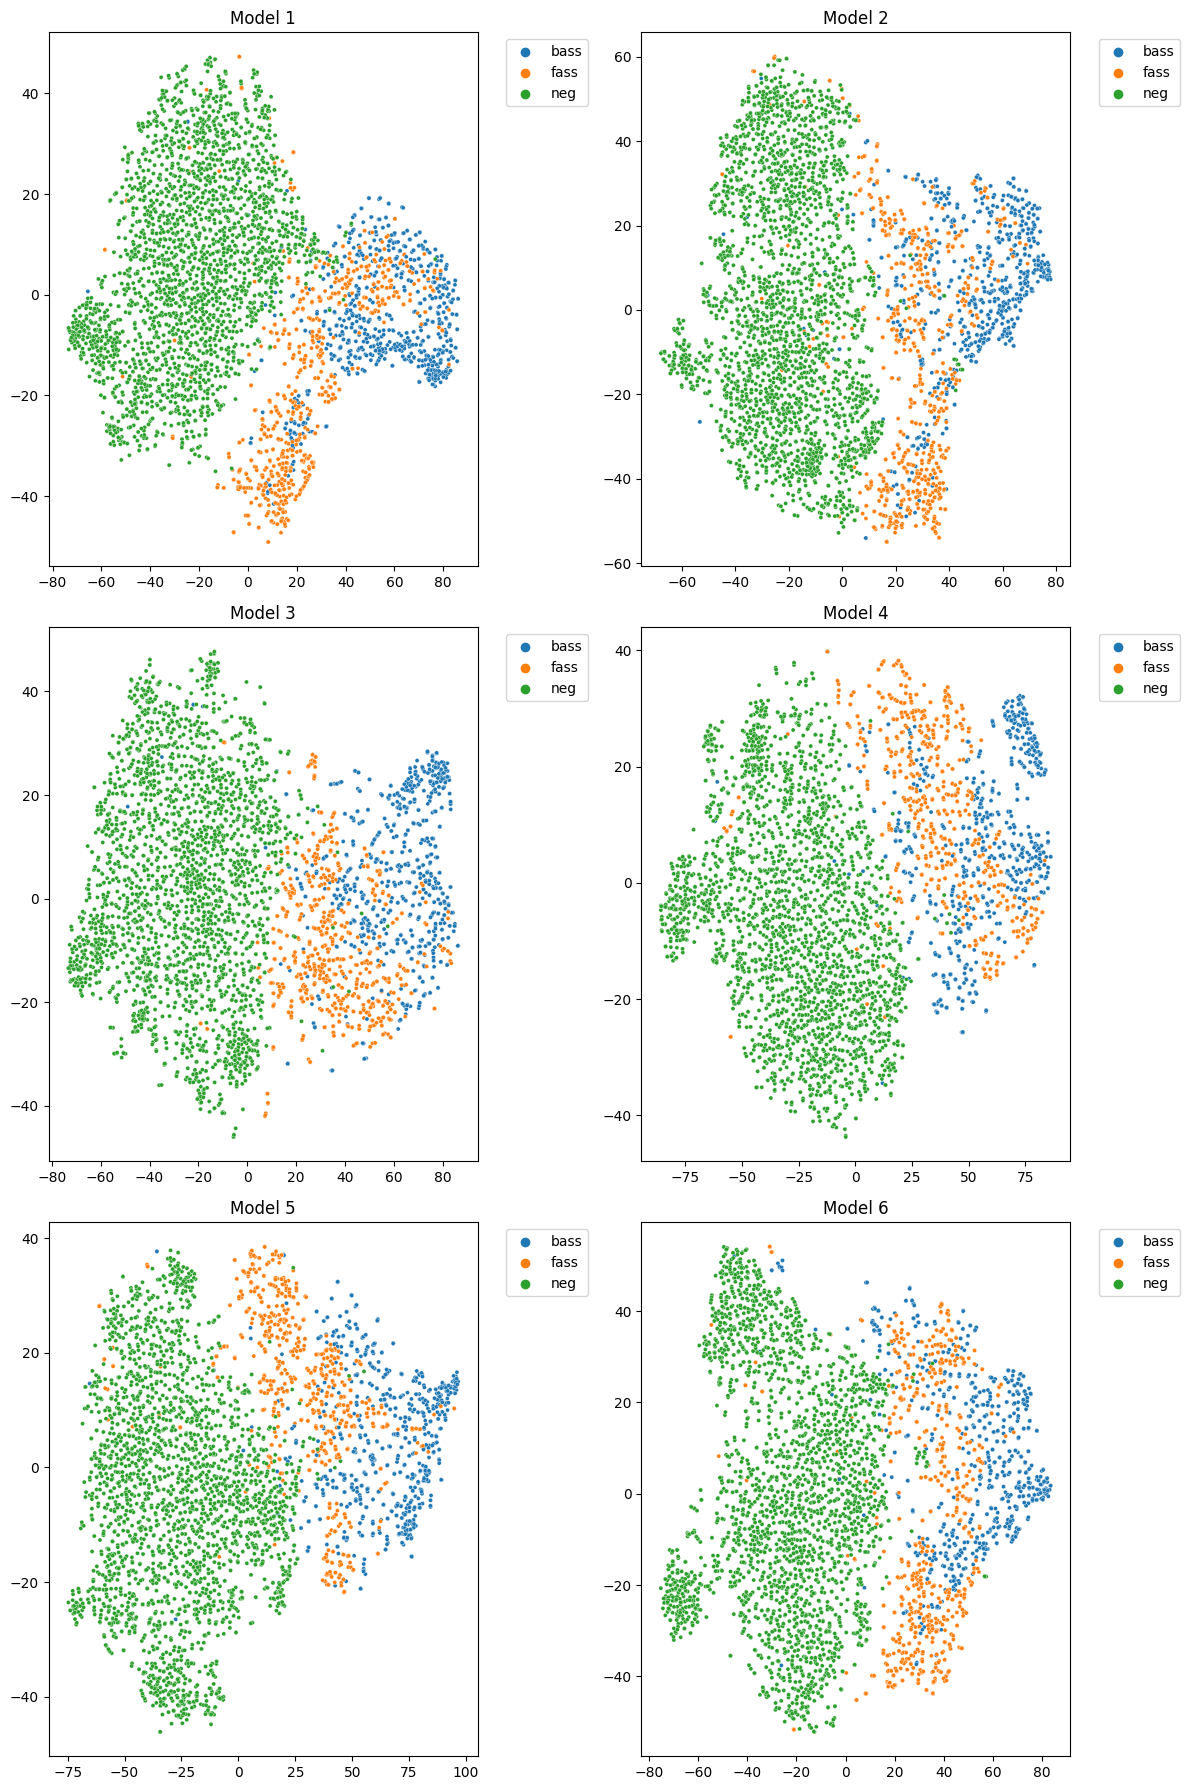

In [2]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(data_path):
    """Loads sequences from a CSV file."""
    df = pd.read_csv(data_path)
    labels = df['label']
    sequences = df['seq']
    return labels, sequences


def cluster_datasets(datasets):
    """Clusters a list of datasets."""
    all_labels = []

    tsne = TSNE(n_components=2, verbose=1, random_state=42)
    embeddings = []
    tsne_embeddings = []
    for i, dataset in enumerate(datasets):
        print("Processing dataset %d/%d" % (i+1, len(datasets)))
        labels, sequences = load_data(dataset)

        for label in labels:
            #all_labels.append(dataset.split('/')[-1].split('.')[0])
            if 'fass' in dataset:
                all_labels.append('fass')
            elif 'bass' in dataset:
                all_labels.append('bass')
            elif 'NLReff' in dataset:
                all_labels.append('neg')

        all_predictions = []
        for i in range(0, len(sequences)):
            seq = sequences[i]
            label = labels[i]
            batch_subsequences = [seq[i:40+i] for i in range(len(seq)-40)]
            if batch_subsequences == []:
                batch_subsequences = [seq]
            preds = model.predict([tokenize_seqs(batch_subsequences, 42), np.zeros((len(batch_subsequences), 8943), dtype=np.int8)], verbose=0)
            # Flattening the predictions and extending all_predictions list
            flattened_preds = [pred[0] for pred in preds[1]]
            max_pred = np.max(flattened_preds)
            max_pred_index = np.argmax(flattened_preds)
            max_sequence = batch_subsequences[max_pred_index]
            #if (max_pred > 0.5 and label == 1) or (max_pred < 0.5 and label == 0):
            all_predictions.append(max_sequence)

        tokens = tokenize_seqs(all_predictions, 42)
        predictions = model.predict([tokens, np.zeros((len(all_predictions), 8943), dtype=np.int8)], verbose=0)

        embeddings.append(np.array(predictions[0]))

        diff = len(labels) - len(all_predictions)
        if diff > 0:
            all_labels = all_labels[:-diff]

    

    tsne_embeddings = tsne.fit_transform(np.concatenate(embeddings))

    # Create scatterplot with legends
    ax = axes[file]

    # Scatter plot
    sns.scatterplot(
        x=[x[0] for x in tsne_embeddings],
        y=[x[1] for x in tsne_embeddings],
        hue=all_labels,
        s=9,
        ax=ax
    )

    # Set plot title and labels
    ax.set_title(f"Model {file+1}")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Display the legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')




for file in os.listdir("./tsne"):
    if file.endswith(".csv"):
        datasets.append(os.path.join("./tsne", file))

# Set the number of rows and columns for the subplots
num_rows = 3
num_cols = 2

# Create a new figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 18))
axes = axes.flatten()


for folder in os.listdir("./proteinbert_models/proteinBERT_full"):

    file = int(folder) - 1
      
    model = tf.keras.models.load_model("./proteinbert_models/proteinBERT_full/" + folder)
    layer_output = model.get_layer('dropout').output
    model = tf.keras.models.Model(inputs=model.input, outputs=[layer_output, model.layers[-1].output])

    cluster_datasets(datasets)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()